In [1]:
import network as nw
import numpy as np 
from scipy.sparse import csr_matrix
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(10)

In [2]:
#collecting data from csv file
data = np.genfromtxt("connections.csv", delimiter=",")
#matrix dimension
N = int(np.max(data)) + 1
#generating the sparse matrix from data
A = csr_matrix((np.ones(len(data)), (data[:, 0], data[:, 1])), shape = (N, N), dtype = np.int32)
#making the network undirected
A = A + A.T
A_w = A
#removing multilinks
A = 1*(A > 0)

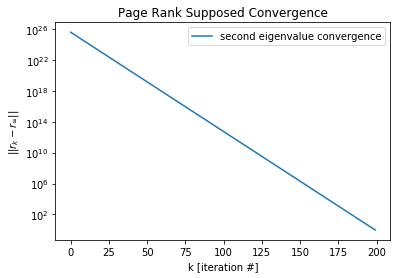

In [3]:
#I want an error that is around 1e-15 so i check the convergence of power iteration
#to find out the number of iterations needed
d = 1 / nw.get_degrees(A)
M = A * sp.sparse.diags(d[:, 0])
v = nw.get_two_highest_eigenvalues(M)
v2 = v[1]

plt.title("Page Rank Supposed Convergence")
ind = np.arange(200)
ref = (0.85*np.abs(v2))**ind
plt.semilogy(ind, ref/ref[-1])
plt.xlabel("k [iteration #]")
plt.ylabel(r"$||r_k - r_\infty||$")
plt.legend(["second eigenvalue convergence"])


In [4]:
#from the previous graph the error is reduced by a factor o 1e15 
#after more or less 125 iterations
num_iter = 125
p = nw.page_rank_power_iteration(A, iter_num = num_iter)

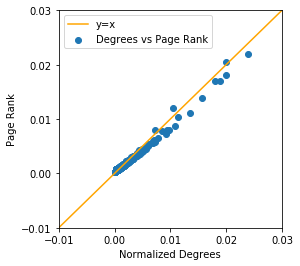

In [5]:
d = nw.get_degrees(A)
plt.figure(figsize=(4,4))
plt.locator_params(nbins=5)
plt.axis([-0.01, 0.03, -0.01, 0.03])
plt.xlabel("Normalized Degrees")
plt.ylabel("Page Rank")
plt.scatter(d/np.sum(d), p)
plt.plot(np.linspace(-0.01, 0.3, 100), np.linspace(-0.01, 0.3, 100), c = "orange")
plt.legend(["y=x", "Degrees vs Page Rank"])


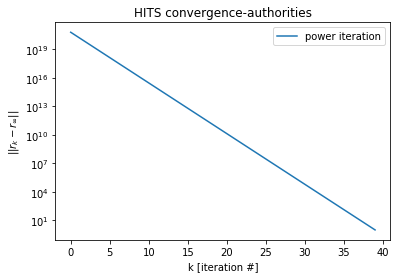

In [6]:
#I want an error that is around 1e-15 so i check the convergence of power iteration
#to find out the number of iterations needed
v = nw.get_two_highest_eigenvalues(A*A.T)

plt.figure()
plt.title("HITS convergence-authorities")
ind = np.arange(40)
ref = np.abs(v[1]/v[0])**ind
plt.semilogy(ind, ref/ref[-1])
plt.xlabel("k [iteration #]")
plt.ylabel(r"$||r_k - r_\infty||$")
plt.legend(["power iteration", "second eigenvalue"])


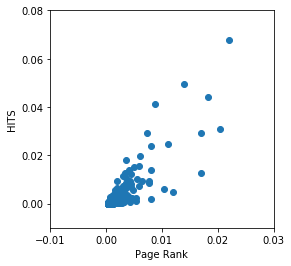

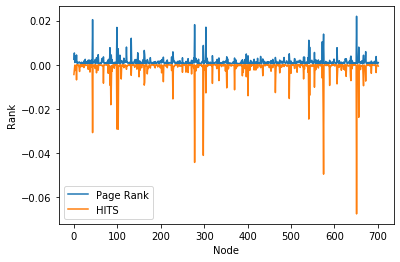

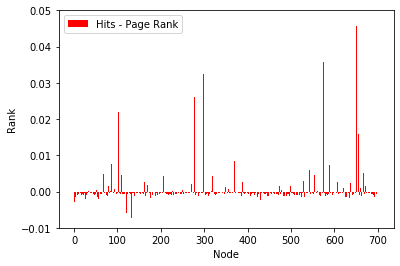

In [7]:
#i see that 40 iterations reduce the error by a reasonable amount
num_iter = 40
r = nw.hits_power_iteration(A_w, iter_num=num_iter)

plt.figure(figsize=(4,4))
#plt.axis("equal")
plt.locator_params(nbins=5)
plt.axis([-0.01, 0.03, -0.01, 0.08])
plt.xlabel("Page Rank")
plt.ylabel("HITS")
plt.scatter(p, r/np.sum(r))

plt.figure()
plt.plot(np.arange(N), p.reshape(-1))
plt.plot(np.arange(N), -r.reshape(-1)/np.sum(r))
plt.legend(["Page Rank", "HITS"])
plt.xlabel("Node")
plt.ylabel("Rank")

plt.figure()
plt.bar(np.arange(N), r.reshape(-1)/np.sum(r) - p.reshape(-1), color="red")
plt.ylim([-0.01, 0.05])
plt.xlabel("Node")
plt.ylabel("Rank")
plt.legend(["Hits - Page Rank"])

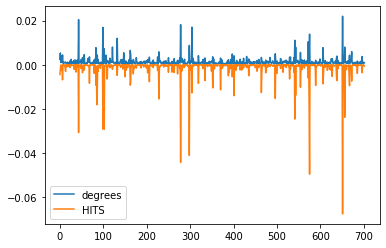

In [8]:
plt.plot(p)
plt.plot(-r/np.sum(r))
plt.legend(["degrees", "HITS"])

In [9]:
#array that contains the name of each character so it's index is it's id
characters_id = []

#reading from file
with open("nodes.csv", "r") as fp:
    for line in fp:
        #for each line get name and id
        name, name_ID = line.replace("\n", "").split(",")
        characters_id.append(name)

In [10]:
#index that would sort from less ranked to most ranked with hits and normal degrees
ids_r = np.argsort(r, axis = 0)
ids_d = np.argsort(d, axis = 0)

#ranking based on the rank difference obtained with the two ranking methods
ids_rd = np.argsort(r-d, axis = 0)

#positions in the ranking the one with the highest rank is assigned position 0
positions = np.arange(N)[::-1]

#getting the position of each character with both rankings
position_d = positions[np.argsort(ids_d, axis = 0)]
position_r = positions[np.argsort(ids_r, axis = 0)]

#points = position
#scores = 
#increment in position with HITS rank compared with the other
delta_pos = position_d - position_r
ids_delta = np.argsort(delta_pos, axis = 0)
characters_r = [characters_id[i[0]] for i in ids_r[::-1]]
characters_d = [characters_id[i[0]] for i in ids_d[::-1]]
characters_rd = [characters_id[i[0]] for i in ids_delta[::-1]]
pos_d = [position_d[i[0]][0] for i in ids_delta[::-1]]
pos_r = [position_r[i[0]][0] for i in ids_delta[::-1]]
pd_dict = {
    "HITS":characters_r, 
    "deg":characters_d
}
pd_imp_dict = {
    "character_improvement":characters_rd,
    "improvement": np.sort(delta_pos, axis = 0)[::-1,0],
    "d_pos": pos_d,
    "r_pos": pos_r

}
df = pd.DataFrame(pd_dict)
df_imp = pd.DataFrame(pd_imp_dict)

In [11]:
df_imp[(df_imp["r_pos"] < 10) | (df_imp["d_pos"] < 10)]

,character_improvement,improvement,d_pos,r_pos
316,Sandor Clegane,9,18,9
320,Cersei Lannister,8,13,5
325,Joffrey Baratheon,5,8,3
331,Sansa Stark,4,5,1
336,Tywin Lannister,2,10,8
339,Tyrion Lannister,0,0,0
343,Jaime Lannister,-1,1,2
350,Robb Stark,-1,6,7
355,Arya Stark,-2,2,4
358,Catelyn Stark,-3,3,6


In [12]:
df.head()

,HITS,deg
0,Tyrion Lannister,Tyrion Lannister
1,Sansa Stark,Jaime Lannister
2,Jaime Lannister,Arya Stark
3,Joffrey Baratheon,Catelyn Stark
4,Arya Stark,Jon Snow


In [13]:
def print_community(community, character_id, weights=None):
    if weights is None:
        print([character_id[idx] for idx in community])
    else:
        maxes = np.max(weights, axis = 1)
        ordered_comm = np.argsort(weights, axis = 1)
        ids = np.argsort(maxes)
        f = lambda x: "{0} {1:.2f}, second community {2} with prob {3:.2f}".format(
            character_id[community[x]],
            maxes[x],
            ordered_comm[x][-2],
            weights[x][ordered_comm[x][-2]]
        )
        characters = map(f, ids)
        for char in characters:
            print(char)

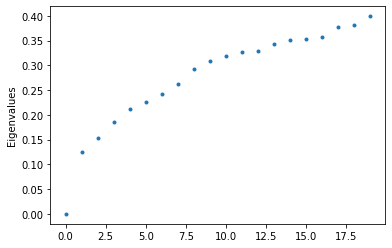

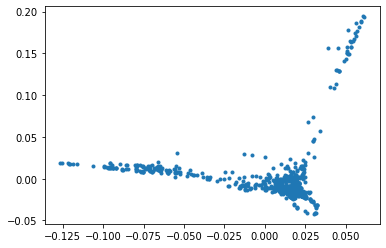

In [14]:
D = nw.get_D_matrix(A)
L = sp.sparse.identity(N) - D*A*D

#getting the eigenvectors of L
eig_val, eig_vec = np.linalg.eigh(L.toarray())
eig_vec = D * eig_vec
eig_vec = eig_vec / np.linalg.norm(eig_vec, axis = 0).reshape(1, -1)

plt.plot(eig_val[0:20], linestyle="None", marker = ".")
plt.ylabel("Eigenvalues")
plt.figure()
plt.plot(eig_vec[:, 1], eig_vec[:, 2], linestyle="None", marker = ".")

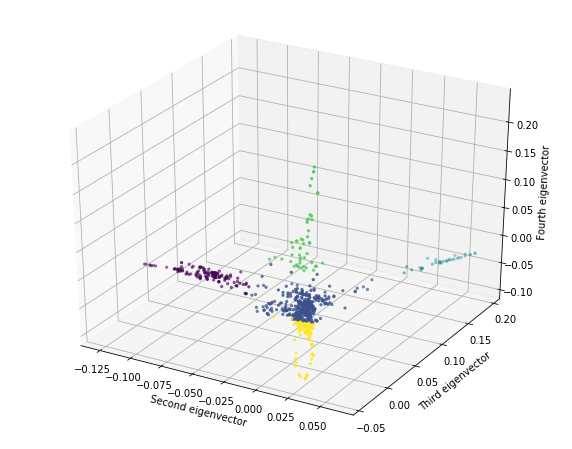

In [15]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D

km = KMeans(n_clusters = 5).fit_predict(eig_vec[:,1:4])
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("Second eigenvector")
ax.set_ylabel("Third eigenvector")
ax.set_zlabel("Fourth eigenvector")
ax.scatter(eig_vec[:, 1], eig_vec[:, 2], eig_vec[:, 3], linestyle="None", marker = ".", c = km)

In [16]:
i = 1
indexes = np.arange(N)
print_community(indexes[km == i], characters_id)

['Addam Marbrand', 'Aegon', 'Aemon Costayne', 'Aenys Frey', 'Aerion Brightflame', 'Aerys II Targaryen', 'Alaric', 'Alayaya', 'Alayne', 'Alerie', 'Alla', 'Allar', 'Alys Karstark', 'Alysanne', 'Amabel', 'Ambrose', 'Amory Lorch', 'Andrew Estermont', 'Arianne', 'Arryk', 'Arthur Dayne', 'Arys Oakheart', 'Ashara Dayne', 'Baelor the Blessed', 'Baelor Hightower', 'Balon Greyjoy', 'Balon Swann', 'Barristan Selmy', 'Beldecar', 'Belis', 'Belmores', 'Ben Plumm', 'Benfrey', 'Bertram Beesbury', 'Bessa', 'Beth', 'Bethany', 'Bethany Fair-fingers', 'Blackshield', 'Boros Blount', 'Botley', 'Brackens', 'Brandon Stark', 'Brella', 'Brienne', 'Bronn', 'Bryen', 'Brynden Tully', 'Lady Bulwer', 'Burley', 'Butterbumps', 'Catelyn Stark', 'Cedrik Storm', 'Cersei Lannister', 'Chataya', 'Chella', 'Chelsted', 'Cleos Frey', 'Cley Cerwyn', 'Collio Quaynis', 'Cortnay Penrose', 'Dacey Mormont', 'Daemon Blackfyre', 'Daemon Sand', 'Daeron', 'Dagos Manwoody', 'Dancy', 'Danny Flint', 'Danwell Frey', 'Daven Lannister', 'Delp

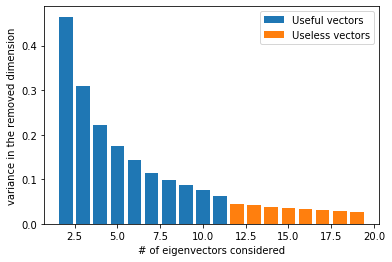

In [17]:
from sklearn.decomposition import PCA
info_given = []
n_max = 20
for i in range(2, n_max):
    pca = PCA(i - 1).fit(eig_vec[:,1:(1+i)])
    info_given.append(1-np.sum(pca.explained_variance_ratio_))
info_given = np.array(info_given)
lim = np.argmax(info_given < 0.05)
plt.bar(range(2, lim + 2), info_given[0:lim])
plt.bar(range(lim + 2, n_max), info_given[lim:n_max-2])
plt.ylabel("variance in the removed dimension")
plt.xlabel("# of eigenvectors considered")
plt.legend(["Useful vectors", "Useless vectors"])

100%|██████████| 48/48 [00:05<00:00,  8.26it/s]


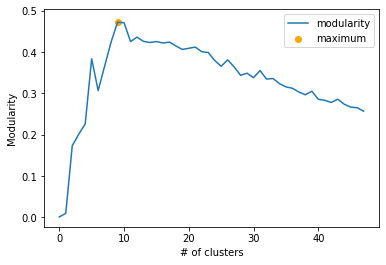

In [18]:
from tqdm import tqdm
modularity = []
kmax = 50
for i in tqdm(range(2, kmax)):
    km = KMeans(n_clusters = i).fit_predict(eig_vec[:,1:(lim+1)])
    modularity.append(nw.get_modularity(A, km))
plt.plot(modularity)
plt.xlabel("# of clusters")
plt.ylabel("Modularity")
amax = np.argmax(np.array(modularity)) + 2
plt.scatter(amax - 2, modularity[amax - 2], c = "orange")
plt.legend(["modularity", "maximum"])
km = KMeans(n_clusters = amax).fit_predict(eig_vec[:, 1:(lim+1)])

In [19]:
i = 11
indexes = np.arange(N)
print_community(indexes[km == i], characters_id)

[]


100%|██████████| 48/48 [00:05<00:00,  8.99it/s]


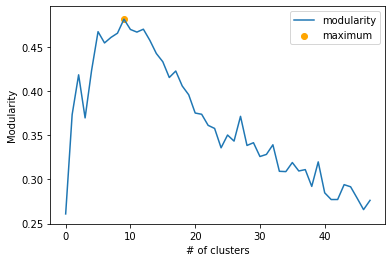

In [20]:
modularity = []
kmax = 50
for i in tqdm(range(2, kmax)):
    km = GaussianMixture(n_components = i).fit_predict(eig_vec[:,1:(lim+1)])
    modularity.append(nw.get_modularity(A, km))
plt.plot(modularity)
plt.xlabel("# of clusters")
plt.ylabel("Modularity")
amax = np.argmax(np.array(modularity)) + 2
plt.scatter(amax - 2, modularity[amax - 2], c = "orange")
plt.legend(["modularity", "maximum"])
gm = GaussianMixture(n_components = amax).fit(eig_vec[:, 1:(lim+1)])
probas = gm.predict_proba(eig_vec[:,1:(lim+1)])
classes = np.argmax(probas, axis = 1)

In [21]:
i = 9
indexes = np.arange(N).reshape(N)
print_community(indexes[classes == i], characters_id, probas[classes==i, :])
Daenerys = indexes[classes == 0]
Lannisters = indexes[classes == 1]
Robb = indexes[classes == 6]
Free_folks = indexes[classes == 7]
Stannis = indexes[classes == 8]
Night_watch = indexes[classes == 9]

Dyah 0.75, second community 7 with prob 0.25
Endrew Tarth 0.98, second community 7 with prob 0.02
Benjen Stark 1.00, second community 7 with prob 0.00
Jarman Buckwell 1.00, second community 7 with prob 0.00
Emmett 1.00, second community 7 with prob 0.00
Jaremy Rykker 1.00, second community 7 with prob 0.00
Ryswell 1.00, second community 3 with prob 0.00
Talla 1.00, second community 7 with prob 0.00
Denys Mallister 1.00, second community 7 with prob 0.00
Othell Yarwyck 1.00, second community 7 with prob 0.00
Owen Norrey 1.00, second community 6 with prob 0.00
Hareth 1.00, second community 7 with prob 0.00
Septon Cellador 1.00, second community 7 with prob 0.00
Bowen Marsh 1.00, second community 7 with prob 0.00
Donal Noye 1.00, second community 7 with prob 0.00
Three-Finger Hobb 1.00, second community 7 with prob 0.00
Jeor Mormont 1.00, second community 6 with prob 0.00
Aemon Targaryen 1.00, second community 7 with prob 0.00
Clydas 1.00, second community 7 with prob 0.00
Tim Tangletongu

In [22]:
import warnings
from scipy.sparse import SparseEfficiencyWarning

#ignoring sparse efficiency warning because in this case it is not more efficient to use a lil_matrix
warnings.simplefilter('ignore',SparseEfficiencyWarning)

armies = {
    "Daenerys": Daenerys,
    "Stannis": Stannis,
    "Lannisters": Lannisters,
    "Robb": Robb,
    "Free Folks": Free_folks,
    "Night's watch": Night_watch
}

def check_army_robustness(A, army, ax, name):

    A1 = A[army.reshape(-1), :][:, army.reshape(-1)]
    N = A1.shape[0]
    
    #getting parameters from random and hubs removal
    random_removal, attack_removal = nw.check_robustness(A1)
    
    #getting the GC dimensions
    random = np.array(random_removal[0])/N
    attack = np.array(attack_removal[0])/N

    #getting the breaking points
    break_random = np.argmax(random < 0.05)
    break_attack = np.argmax(attack < 0.05)
    
    #print(f"For random removal inhomogeneity ratio goes below 2 when f = {inh_random/N}")
    #print(f"For attack removal inhomogeneity ratio goes below 2 when f = {inh_attack/N}")

    ax.plot(np.linspace(0, 1, N), random)
    ax.plot(np.linspace(0, 1, N), attack)
    ax.plot(np.linspace(0, 1, N),np.arange(N, 0, -1)/N)
    ax.vlines(break_random/N, 0, 0.1, colors="darkblue")
    ax.vlines(break_attack/N, 0, 0.1, colors="red")
    ax.set_xlabel("f")
    ax.set_title(f"Robustness for the army of {name}")
    ax.legend([
        "Random removal", 
        "Hubs removal", 
        "# of nodes", 
    ])
    ax.set_ylabel("$P_\infty(f)/P_\infty(0)$")


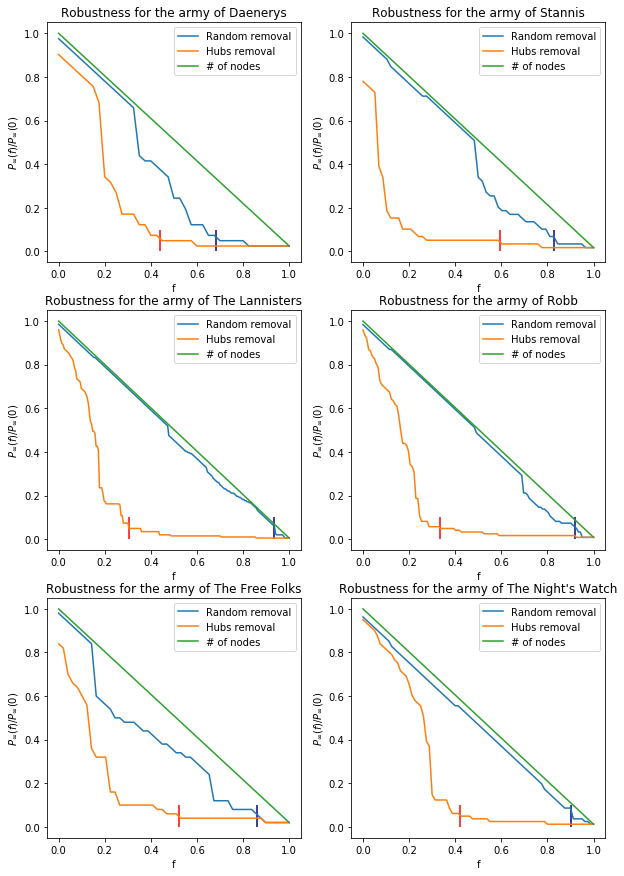

In [23]:
fig, axs = plt.subplots(3,2, figsize=(10,15))
check_army_robustness(A, armies["Daenerys"], axs[0, 0], "Daenerys")
check_army_robustness(A, armies["Stannis"], axs[0, 1], "Stannis")
check_army_robustness(A, armies["Lannisters"], axs[1, 0], "The Lannisters")
check_army_robustness(A, armies["Robb"], axs[1, 1], "Robb")
check_army_robustness(A, armies["Free Folks"], axs[2, 0], "The Free Folks")
check_army_robustness(A, armies["Night's watch"], axs[2, 1], "The Night's Watch")

In [24]:
f = nw.spectral_clustering_reordering

communities, separators = nw.divide_in_communities(A, f, conductance_lim=0.25)
print(len(communities))

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
15


In [25]:
i = 1
print(f'community index = {communities[i]["path"]}')
print(f"community")
chara = communities[i]["indexes"]
chara.sort()
print_community(chara, characters_id)
print(f"borderline character = {characters_id[communities[i]['border']]}")

community index = 01000
community
['Aerion Brightflame', 'Alester Florent', 'Allard', 'Andrew Estermont', 'Axell Florent', 'Azor Ahai', 'Baelor Breakspear', 'Belgrave', 'Betha', 'Butterwell', 'Cafferen', 'Ardrian Celtigar', 'Cobblecat', 'Cressen', 'Daeron', 'Davos Seaworth', 'Delena', 'Devan', 'Edric Storm', 'Emmon Cuy', 'Euron Greyjoy', 'Flement Brax', 'Gerald Gower', 'Gilbert Farring', 'Lord Grandison', 'Guncer Sunglass', 'Helman Tallhart', 'Hookface', 'Hubard Rambton', 'Imry Florent', 'Jate', 'Jenna', 'Joffrey Baratheon', 'Jothos Slynt', 'Khorane Sathmantes', 'Leo Longthorn', 'Lewys', 'Maester Pylos', 'Maric', 'Marya', 'Massey', 'Matthos', 'Meizo Mahr', 'Melisandre', 'Monford', 'Morrigen', 'Morros Slynt', 'Myles Smallwood', 'Nissa Nissa', 'Omer', 'Otto Hightower', 'Patchface', 'Peckledon', 'Prendos', 'Quentyn Martell', 'Randyll Tarly', 'Renly Baratheon', 'Rolland', 'Roro Uhoris', 'R’hllor', 'Salla', 'Salladhor Saan', 'Selsye', 'Septon Barth', 'Septon Murmison', 'Shayala', 'Shireen',

In [26]:
def get_sep_tree(separators, path=""):
    if len(separators) == 3:
        print(f"{characters_id[separators[1]]}, path:{path}")
        get_sep_tree(separators[0] ,path+"0")
        get_sep_tree(separators[2], path+"1")
    elif len(separators) == 1:
        print(f"{characters_id[separators[0]]}, path:{path}")
    elif len(separators) == 2 and type(separators[0]) == np.int64:
        print(f"{characters_id[separators[0]]}, path:{path}")
        get_sep_tree(separators[1], path+"1")
    else:
        print(f"{characters_id[separators[1]]}, path:{path}")
        get_sep_tree(separators[0], path+"0")
get_sep_tree(separators)

Gage, path:
Lyonel Selmy, path:0
Merry Crane, path:01
Stafford, path:010
Aerion Brightflame, path:0100
Arys Oakheart, path:0101
Bessa, path:01011
Nage, path:011
Megga, path:0110
Nage, path:01101
Garse Goodbrook, path:0111
Jarman Buckwell, path:1
Jeor Mormont, path:11
Knott, path:110


In [27]:
auc_roc = {}
precision = {}

In [28]:
rwwr = "Random walk with restart"
lrw = "Local random walk"
srw = "Superposed random walk"
cn = "Common neighbours"
aa = "Adamic Adar"
ra = "Resource Allocation"

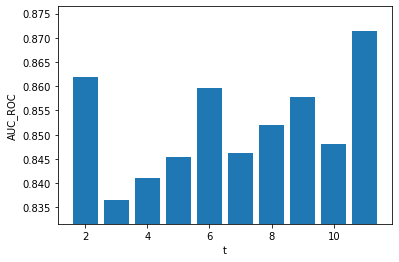

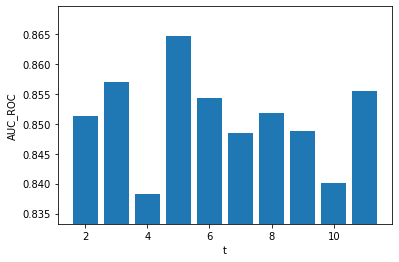

In [29]:
auc_roc[rwwr] = nw.ROC_AUC(A, nw.random_walk_with_restart_link_prediction)
precision[rwwr] = nw.precision(A, nw.random_walk_with_restart_link_prediction)

roc_aucs = []
t_range = range(2, 12)
for t in t_range:
    roc_aucs.append(nw.ROC_AUC(A, nw.local_random_walk_link_prediction, [t]))

roc_aucs = np.array(roc_aucs)
plt.bar(t_range, roc_aucs )
plt.ylim([np.min(roc_aucs) - 0.005, np.max(roc_aucs) + 0.005])
plt.ylabel("AUC_ROC")
plt.xlabel("t")
best_t = [t_range[np.argmax(np.array(roc_aucs))]]
auc_roc[lrw] = nw.ROC_AUC(A, nw.local_random_walk_link_prediction, best_t)
precision[lrw] = nw.precision(A, nw.local_random_walk_link_prediction, best_t)

roc_aucs = []
for t in t_range:
    roc_aucs.append(nw.ROC_AUC(A, nw.superposed_random_walk_link_prediction, [t]))

plt.figure()
roc_aucs = np.array(roc_aucs)
plt.bar(t_range, roc_aucs )
plt.ylabel("AUC_ROC")
plt.xlabel("t")
plt.ylim([np.min(roc_aucs)-0.005, np.max(roc_aucs)+0.005])
best_t = [t_range[np.argmax(np.array(roc_aucs))]]
auc_roc[srw] = nw.ROC_AUC(A, nw.superposed_random_walk_link_prediction, best_t)
precision[srw] = nw.precision(A, nw.superposed_random_walk_link_prediction, best_t)

In [30]:
auc_roc[cn] = nw.ROC_AUC(A, nw.common_neigh_link_prediction)
precision[cn] = nw.precision(A, nw.common_neigh_link_prediction)
auc_roc[aa] = nw.ROC_AUC(A, nw.adamic_adar_link_prediction)
precision[aa] = nw.precision(A, nw.adamic_adar_link_prediction)
auc_roc[ra] = nw.ROC_AUC(A, nw.resource_allocation_link_prediction)
precision[ra] = nw.precision(A, nw.resource_allocation_link_prediction)

In [31]:
l = range(2, 7)
beta = [0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001]
katz_res = np.zeros((len(l), len(beta)))
for i, l_i in enumerate(l):
    for j, b in enumerate(beta):
        roc_auc = nw.ROC_AUC(A, nw.katz_link_prediction, (l_i, b))
        katz_res[i, j] = roc_auc

Text(33.0, 0.5, '$l_{max}$')

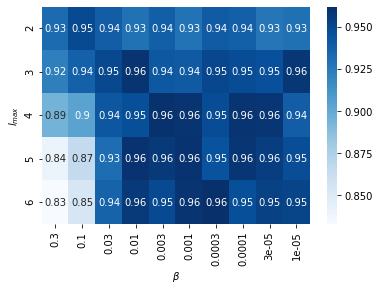

In [32]:
import seaborn as sns
ax = sns.heatmap(katz_res, cmap = "Blues", xticklabels=beta, yticklabels=l, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xlabel("$\\beta$")
ax.set_ylabel("$l_{max}$")

In [33]:
rows, cols = np.unravel_index(np.argmax(katz_res), katz_res.shape)
print(l[rows], beta[cols])

6 0.0003


In [34]:
auc_roc["katz"] = nw.ROC_AUC(A, nw.katz_link_prediction, (l[rows], beta[cols]))
precision["katz"] = nw.precision(A, nw.katz_link_prediction, (l[rows], beta[cols]))

In [35]:
df = pd.DataFrame({"AUC_ROC":auc_roc, "Precision":precision})
df.head(10)

,AUC_ROC,Precision
Random walk with restart,0.975374,0.292343
Local random walk,0.845168,0.071926
Superposed random walk,0.834694,0.058005
Common neighbours,0.938389,0.197216
Adamic Adar,0.964562,0.243619
Resource Allocation,0.975685,0.385151
katz,0.938958,0.197216


In [36]:
df.to_latex()

'\\begin{tabular}{lrr}\n\\toprule\n{} &   AUC\\_ROC &  Precision \\\\\n\\midrule\nRandom walk with restart &  0.975374 &   0.292343 \\\\\nLocal random walk        &  0.845168 &   0.071926 \\\\\nSuperposed random walk   &  0.834694 &   0.058005 \\\\\nCommon neighbours        &  0.938389 &   0.197216 \\\\\nAdamic Adar              &  0.964562 &   0.243619 \\\\\nResource Allocation      &  0.975685 &   0.385151 \\\\\nkatz                     &  0.938958 &   0.197216 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [37]:
def get_next_link_with_char(character, links, characters_id):
    i = 0
    while (characters_id[new_links[i][0]] != character) and (characters_id[new_links[i][1]] != character):
        i += 1
    return i 
    

In [38]:
S = nw.resource_allocation_link_prediction(A) 
new_links = nw.get_new_links(S, 2000)
max_len = 20

for link in new_links[:max_len]:
    print(characters_id[link[0]],"<->", characters_id[link[1]])


Daenerys Targaryen <-> Tyrion Lannister
Davos Seaworth <-> Sam Tarly
Arya Stark <-> Daenerys Targaryen
Catelyn Stark <-> Sam Tarly
Jaime Lannister <-> Lothar Frey
Gregor Clegane <-> Sansa Stark
Brienne <-> Tywin Lannister
Devan <-> Stannis Baratheon
Kevan Lannister <-> Robb Stark
Hosteen Frey <-> Raymund Frey
Barristan Selmy <-> Daario Naharis
Ami <-> Walder Frey
Davos Seaworth <-> Sansa Stark
Alyn Connington <-> Pate of Lancewood
Brandon Stark <-> Mance Raydar
Arya Stark <-> Bronn
Aemon Targaryen <-> Bowen Marsh
Edmure Tully <-> Sandor Clegane
Aegon <-> Aemon Targaryen
Ben Plumm <-> Simon Toyne


In [39]:
i = get_next_link_with_char("Jon Snow", new_links, characters_id)
print("Next connection to Jon Snow")
print(characters_id[new_links[i][0]],"<->", characters_id[new_links[i][1]])
print()

i = get_next_link_with_char("Roose Bolton", new_links, characters_id)
print("Next connection to Roose")
print(characters_id[new_links[i][0]],"<->", characters_id[new_links[i][1]])
print()

i = get_next_link_with_char("Cersei Lannister", new_links, characters_id)
print("Next connection to Cersei Lannister")
print(characters_id[new_links[i][0]],"<->", characters_id[new_links[i][1]])

Next connection to Jon Snow
Aegon <-> Jon Snow

Next connection to Roose
Roose Bolton <-> Sansa Stark

Next connection to Cersei Lannister
Cersei Lannister <-> Roose Bolton
